# Predicting T-shirt size using the ANSUR II dataset
We will here try to predict a persons t-shirt size given the weight and height of the person. We will use the ANSUR II dataset which contains a lot of information about the physical attributes of a large number of people. 

We will first try to map the persons in the dataset to a t-shirt size. It is hard to find a concise size chart for t-shirt so we will create our own, initial chart, based on these assumptions:

We will only look at two measurements, Shoulder Width and Chest Circumference.

Our first problem is that Shoulder Width is not one of the measurements taken in the dataset. But we have Biacromial Breadth which is the distance between the two acromion processes. We will assume that this is the same as Shoulder Width.

We will then have these initial rules:

| Size | Percentile |
|------|------------|
| XS   | 0-5        |
| S    | 5-25       |
| M    | 25-50      |
| L    | 50-75      |
| XL   | 75-90      |
| XXL  | 90-97      |
| XXXL | 97-100     |

## Inspect the data

In [1]:
import pandas as pd

female = pd.read_csv('./data/female.csv')
male = pd.read_csv('./data/male.csv')


In [2]:
print(f'For women we have (rows, columns) {female.shape}')
print(f'For men we have (rows, columns) {male.shape}')


For women we have (rows, columns) (1986, 108)
For men we have (rows, columns) (4082, 108)


## Checking the percentiles

Let us determine the percentiles of the data.

In [3]:
def compute_percentile_ranges(column):
    # Define percentile ranges
    ranges = [(0,5), (5,25), (25, 50), (50, 75), (75, 90), (90,97), (97,100)]

    # Beräkna percentiler för varje specificerat intervall
    percentiles = {(low, high): (column.quantile(low/100), column.quantile(high/100)) for low, high in ranges}

    # Räkna antalet poster som faller inmom varje percentilintervall
    counts = {}

    for r, (low,high) in percentiles.items():
        counts[r] = ((column >= low) & (column < high)).sum()
    return counts

# Beräkna och skriv ut percentilintervall för kvinnor och mäns bröskrets och biakromialbredd
print(compute_percentile_ranges(female['chestcircumference']))
print(compute_percentile_ranges(female['biacromialbreadth']))

print(compute_percentile_ranges(male['chestcircumference']))
print(compute_percentile_ranges(male['biacromialbreadth']))






{(0, 5): 100, (5, 25): 396, (25, 50): 492, (50, 75): 499, (75, 90): 299, (90, 97): 140, (97, 100): 59}
{(0, 5): 93, (5, 25): 377, (25, 50): 477, (50, 75): 541, (75, 90): 297, (90, 97): 139, (97, 100): 61}
{(0, 5): 199, (5, 25): 810, (25, 50): 1025, (50, 75): 1012, (75, 90): 616, (90, 97): 295, (97, 100): 124}
{(0, 5): 191, (5, 25): 787, (25, 50): 989, (50, 75): 1079, (75, 90): 610, (90, 97): 303, (97, 100): 122}


## Generate the t-shirt size chart

In [4]:
def compute_size_percentile_measurments(data, chest_column, shoulder_column):
    sizes = ['XS', 'S', 'M', 'L', 'XL', '2XL', '3XL']
    ranges = [0, 5, 25, 50, 75, 90, 97]

    # Compute the values for each percentile for chest and shoulder
    # Beräkna kvantilvärden för bröst- och axelmått
    chest_percentiles = {p: data[chest_column].quantile(p/100) for p in ranges}
    shoulder_percentiles = {p: data[shoulder_column].quantile(p/100) for p in ranges}
    
    # Map the t-shirt sizes to the corresponding chest and shoulder measurments
    # Tilldela varje storlek till det beräknade måttet från percentilerna
    size_mappings = {}
    for i, size in enumerate(sizes):
        size_mappings[size] = {
            'Chest' : int(chest_percentiles[ranges[i]]),
            'Shoulder': int(shoulder_percentiles[ranges[i]])
        }
    return size_mappings


print(compute_size_percentile_measurments(female, 'biacromialbreadth', 'biacromialbreadth'))
print(compute_size_percentile_measurments(male, 'chestcircumference', 'biacromialbreadth'))



{'XS': {'Chest': 283, 'Shoulder': 283}, 'S': {'Chest': 335, 'Shoulder': 335}, 'M': {'Chest': 353, 'Shoulder': 353}, 'L': {'Chest': 365, 'Shoulder': 365}, 'XL': {'Chest': 378, 'Shoulder': 378}, '2XL': {'Chest': 389, 'Shoulder': 389}, '3XL': {'Chest': 400, 'Shoulder': 400}}
{'XS': {'Chest': 774, 'Shoulder': 337}, 'S': {'Chest': 922, 'Shoulder': 384}, 'M': {'Chest': 996, 'Shoulder': 403}, 'L': {'Chest': 1056, 'Shoulder': 415}, 'XL': {'Chest': 1117, 'Shoulder': 428}, '2XL': {'Chest': 1172, 'Shoulder': 441}, '3XL': {'Chest': 1233, 'Shoulder': 452}}


In [5]:
female_sizes = {
    'XS': {'Chest': 695, 'Shoulder': 283}, 
    'S': {'Chest': 824, 'Shoulder': 335}, 
    'M': {'Chest': 889, 'Shoulder': 353}, 
    'L': {'Chest': 940, 'Shoulder': 365}, 
    'XL': {'Chest': 999, 'Shoulder': 378}, 
    '2XL': {'Chest': 1057, 'Shoulder': 389}, 
    '3XL': {'Chest': 1117, 'Shoulder': 400}
    }

male_sizes = {
    'XS': {'Chest': 774, 'Shoulder': 337}, 
    'S': {'Chest': 922, 'Shoulder': 384}, 
    'M': {'Chest': 996, 'Shoulder': 403}, 
    'L': {'Chest': 1056, 'Shoulder': 415}, 
    'XL': {'Chest': 1117, 'Shoulder': 428}, 
    '2XL': {'Chest': 1172, 'Shoulder': 441}, 
    '3XL': {'Chest': 1233, 'Shoulder': 452}
    }
    

In [6]:
def get_size(data, size_chart): 
    # Skapa en dict. för att räkna antalet matchningar för varje storlek
    matches = {size: 0 for size in size_chart.keys()}
    #Variabel för att räkna antalet situationerdär det finns flera möjliga storlekar
    ties = 0

    # Loopa igenom varje rad i data
    for _, row in data.iterrows():
        # Lista för att hålla de möjliga storlekarna för den aktuella personen
        possible_sizes = []

        # Loopa igenom varje storlek i strlk.tabellen
        for size, measurments in size_chart.items():
            # Kontrollera om personens mått passar inom måttet för den aktuella strlk.
            if (row['biacromialbreadth'] <= measurments['Shoulder'] and
                row['chestcircumference'] <= measurments['Chest']):
                possible_sizes.append(size)

        # Om det bara finns en möjlig strlk., öka räknaren för den storleken
        if len(possible_sizes) == 1:
                matches[possible_sizes[0]] += 1
        # Om det finns flera möjliga strlkar, öka räknaren för ties
        elif len(possible_sizes) > 1: 
                ties += 1
    
    return matches, ties

In [7]:
female_matches, female_ties = get_size(female, female_sizes)
male_matches, male_ties = get_size(male, male_sizes)

print('Female matches:', female_matches)
print('Female ties:', female_ties)
print('Male matches:', male_matches)
print('Male ties:', male_ties)



Female matches: {'XS': 0, 'S': 0, 'M': 0, 'L': 0, 'XL': 0, '2XL': 0, '3XL': 236}
Female ties: 1642
Male matches: {'XS': 0, 'S': 0, 'M': 0, 'L': 0, 'XL': 0, '2XL': 0, '3XL': 434}
Male ties: 3437


This is not good. Let us have overlapping measurments.

In [8]:
def create_overlapping_size_chart(original_chart):
    overlapping_chart = {}

    # HÄmta en lista med storlekarna från den ursprungliga storlekstabellen
    sizes = list(original_chart.keys())

    # Loopa igenom varje strlk.
    for i, size in enumerate(sizes):
        # Skapa en inre dict. för varje strlk. i den nya tabellen
        overlapping_chart[size] = {}
        # Hantera specialfall för första och sista strlk.
        if i == 0:
            # extra 5 enheter som övre gräns
            overlapping_chart[size]['Chest'] = [original_chart[size]['Chest'], original_chart[sizes[i+1]]['Chest']+5]
            overlapping_chart[size]['Shoulder'] = [original_chart[size]['Shoulder'], original_chart[sizes[i+1]]['Shoulder']+5]
        
        elif i == len(sizes)-1:
            # nedre-> minus 5 enheter...övre-> plus 1000 enheter
            overlapping_chart[size]['Chest'] = [original_chart[size]['Chest']-5, original_chart[size]['Chest']+1000]
            overlapping_chart[size]['Shoulder'] = [original_chart[size]['Shoulder']-5, original_chart[size]['Shoulder']+1000]
        
        else:
            overlapping_chart[size]['Chest'] = [original_chart[size]['Chest']-5, original_chart[sizes[i+1]]['Chest']+5]
            overlapping_chart[size]['Shoulder'] = [original_chart[size]['Shoulder']-5, original_chart[sizes[i+1]]['Shoulder']+5]

    # Returnera den nya strlk.tabellen med överlappande mått
    return overlapping_chart





In [9]:
new_female_sizes = create_overlapping_size_chart(female_sizes)
new_male_sizes = create_overlapping_size_chart(male_sizes)

for k, v in new_female_sizes.items():
    print(f"'{k}' : {v},")

print()

for k, v in new_male_sizes.items():
    print(f"'{k}' : {v},")

'XS' : {'Chest': [695, 829], 'Shoulder': [283, 340]},
'S' : {'Chest': [819, 894], 'Shoulder': [330, 358]},
'M' : {'Chest': [884, 945], 'Shoulder': [348, 370]},
'L' : {'Chest': [935, 1004], 'Shoulder': [360, 383]},
'XL' : {'Chest': [994, 1062], 'Shoulder': [373, 394]},
'2XL' : {'Chest': [1052, 1122], 'Shoulder': [384, 405]},
'3XL' : {'Chest': [1112, 2117], 'Shoulder': [395, 1400]},

'XS' : {'Chest': [774, 927], 'Shoulder': [337, 389]},
'S' : {'Chest': [917, 1001], 'Shoulder': [379, 408]},
'M' : {'Chest': [991, 1061], 'Shoulder': [398, 420]},
'L' : {'Chest': [1051, 1122], 'Shoulder': [410, 433]},
'XL' : {'Chest': [1112, 1177], 'Shoulder': [423, 446]},
'2XL' : {'Chest': [1167, 1238], 'Shoulder': [436, 457]},
'3XL' : {'Chest': [1228, 2233], 'Shoulder': [447, 1452]},


In [10]:
female_sizes = {
'XS' : {'Chest': [695, 829], 'Shoulder': [283, 340]},
'S' : {'Chest': [819, 894], 'Shoulder': [330, 358]},
'M' : {'Chest': [884, 945], 'Shoulder': [348, 370]},
'L' : {'Chest': [935, 1004], 'Shoulder': [360, 383]},
'XL' : {'Chest': [994, 1062], 'Shoulder': [373, 394]},
'2XL' : {'Chest': [1052, 1122], 'Shoulder': [384, 405]},
'3XL' : {'Chest': [1112, 2117], 'Shoulder': [395, 1400]}
}

male_sizes = {
'XS' : {'Chest': [774, 927], 'Shoulder': [337, 389]},
'S' : {'Chest': [917, 1001], 'Shoulder': [379, 408]},
'M' : {'Chest': [991, 1061], 'Shoulder': [398, 420]},
'L' : {'Chest': [1051, 1122], 'Shoulder': [410, 433]},
'XL' : {'Chest': [1112, 1177], 'Shoulder': [423, 446]},
'2XL' : {'Chest': [1167, 1238], 'Shoulder': [436, 457]},
'3XL' : {'Chest': [1228, 2233], 'Shoulder': [447, 1452]}
}

In [11]:
def get_size(data, size_chart):
    matches = {size: 0 for size in size_chart.keys()}
    ties = 0

    # Hämta en lista med storlk. i ordning
    size_ordered = list(size_chart.keys())


    for _, row in data.iterrows():
        possible_sizes = []

        for size, measurments in size_chart.items():
            # Kontrollera om personens mått ligger inom intervallet för den aktuella strlk
            if (row['biacromialbreadth'] >= measurments['Shoulder'][0] and
                row['biacromialbreadth'] <= measurments['Shoulder'][1] and
                row['chestcircumference'] >= measurments['Chest'][0] and
                row['chestcircumference'] <= measurments['Chest'][1]):
                possible_sizes.append(size)
        
        if len(possible_sizes) == 1: 
            matches[possible_sizes[0]] += 1
        elif len(possible_sizes) > 1:
            #Check if sizes are adjacent
            are_adjacent = all([abs(size_ordered.index(possible_sizes[i])- size_ordered.index(possible_sizes[i+1])) == 1
                                for i in range(len(possible_sizes)-1)])
            
            if are_adjacent:
                #Assign the larger size
                larger_size = max(possible_sizes, key=lambda s: size_ordered.index(s))
                matches[larger_size] += 1
            else:
                ties += 1

    return matches, ties


                


In [12]:
result = all([True, True, True])
print(result)

x=10
result = all([x<15, x==10, x>12])
print(result)

True
False


In [13]:
female_matches, female_ties = get_size(female, female_sizes)
male_matches, male_ties = get_size(male, male_sizes)

print('Female matches:', female_matches)
print('Female ties:', female_ties)
print('Male matches:', male_matches)
print('Male ties:', male_ties)



Female matches: {'XS': 23, 'S': 185, 'M': 247, 'L': 276, 'XL': 118, '2XL': 35, '3XL': 13}
Female ties: 0
Male matches: {'XS': 63, 'S': 428, 'M': 578, 'L': 593, 'XL': 331, '2XL': 101, '3XL': 50}
Male ties: 0


In [14]:
def determine_size(value, measurement, size_dict):
    """
    Determine clothing sizes that match the given body measurement value.
    
    Iterates through the provided size dictionary and finds all sizes where the 
    measurement range contains the given value.
    
    Parameters:
      value: The body measurement value
      measurement: The name of the measurement type
      size_dict: Dictionary mapping clothing sizes to measurement ranges
    
    Returns:
      sizes: List of clothing sizes matching the measurement value
    """
    sizes = []
    for size, measurements in size_dict.items():
        if measurements[measurement][0] <= value <= measurements[measurement][1]:
            sizes.append(size)
    return sizes

def determine_individual_size(row, size_dict):
    """
    Determine individual clothing size based on chest circumference and shoulder width.
    Matches the chest and shoulder measurements to clothing sizes in the provided size dictionary. 
    Returns a single matching size, or the larger of two adjacent sizes if there are multiple matches.
    Returns None if no size matches or adjacent sizes cannot be determined.
    """
    chest_size = determine_size(row['chestcircumference'], 'Chest', size_dict)
    shoulder_size = determine_size(row['biacromialbreadth'], 'Shoulder', size_dict)
    
    matching_sizes = list(set(chest_size) & set(shoulder_size))
    
    if len(matching_sizes) == 1:
        return matching_sizes[0]
    elif len(matching_sizes) > 1:
        # Check if sizes are adjacent, if so, select the larger size
        size_order = list(size_dict.keys())
        adjacent = all([abs(size_order.index(a) - size_order.index(b)) <= 1 for a in matching_sizes for b in matching_sizes])
        if adjacent:
            return max(matching_sizes, key=lambda x: size_order.index(x))
    return None

In [15]:
# Skapa en ny kolumn kallad "t-shirt size" för både kvinnliga och manliga dataseten.
female['t-shirt size'] = female.apply(determine_individual_size, args =(female_sizes,), axis=1)
male['t-shirt size'] = male.apply(determine_individual_size, args =(male_sizes,), axis=1)


In [16]:
# Räknar och returnerar antalet förekomster av varje unikt värde
female['t-shirt size'].value_counts()

t-shirt size
L      276
M      247
S      185
XL     118
2XL     35
XS      23
3XL     13
Name: count, dtype: int64

In [17]:
male['t-shirt size'].value_counts()

t-shirt size
L      593
M      578
S      428
XL     331
2XL    101
XS      63
3XL     50
Name: count, dtype: int64

In [19]:
female_filtered = female.dropna(subset=['t-shirt size'])
male_filtered = male.dropna(subset=['t-shirt size'])

In [20]:
female_filtered.shape

(897, 109)

In [21]:
male_filtered.shape

(2144, 109)

In [22]:
columns = ['chestcircumference', 'biacromialbreadth', 'weightkg', 'stature', 't-shirt size']

female_dataset = female_filtered[columns]
male_dataset = male_filtered[columns]

In [23]:
female_dataset.to_csv('./data/female_sized.csv', index=False)
male_dataset.to_csv('./data/male_sized.csv', index=False)


## Scatter plot

1. visualisera fördelningen av t-shirtstorlekar
2. Identifiera mönster eller trender
3. Jämföra män och kvinnor
4. Kommunicera resultat
5. Identifiera eventuella anomali eller avvikelser

C:\Users\AladdinElkhatib\AppData\Local\Temp\ipykernel_4016\2214390950.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[173.5 181.  185.  ... 176.5 169.  182.8]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  male_dataset.loc[:, 'stature'] = male_dataset['stature'] / 10
C:\Users\AladdinElkhatib\AppData\Local\Temp\ipykernel_4016\2214390950.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 92.9 116.2  95.4 ...  89.6  83.2  98.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  male_dataset.loc[:, 'weightkg'] = male_dataset['weightkg'] / 10
C:\Users\AladdinElkhatib\AppData\Local\Temp\ipykernel_4016\2214390950.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[166.  167.1 152.1 166.8 

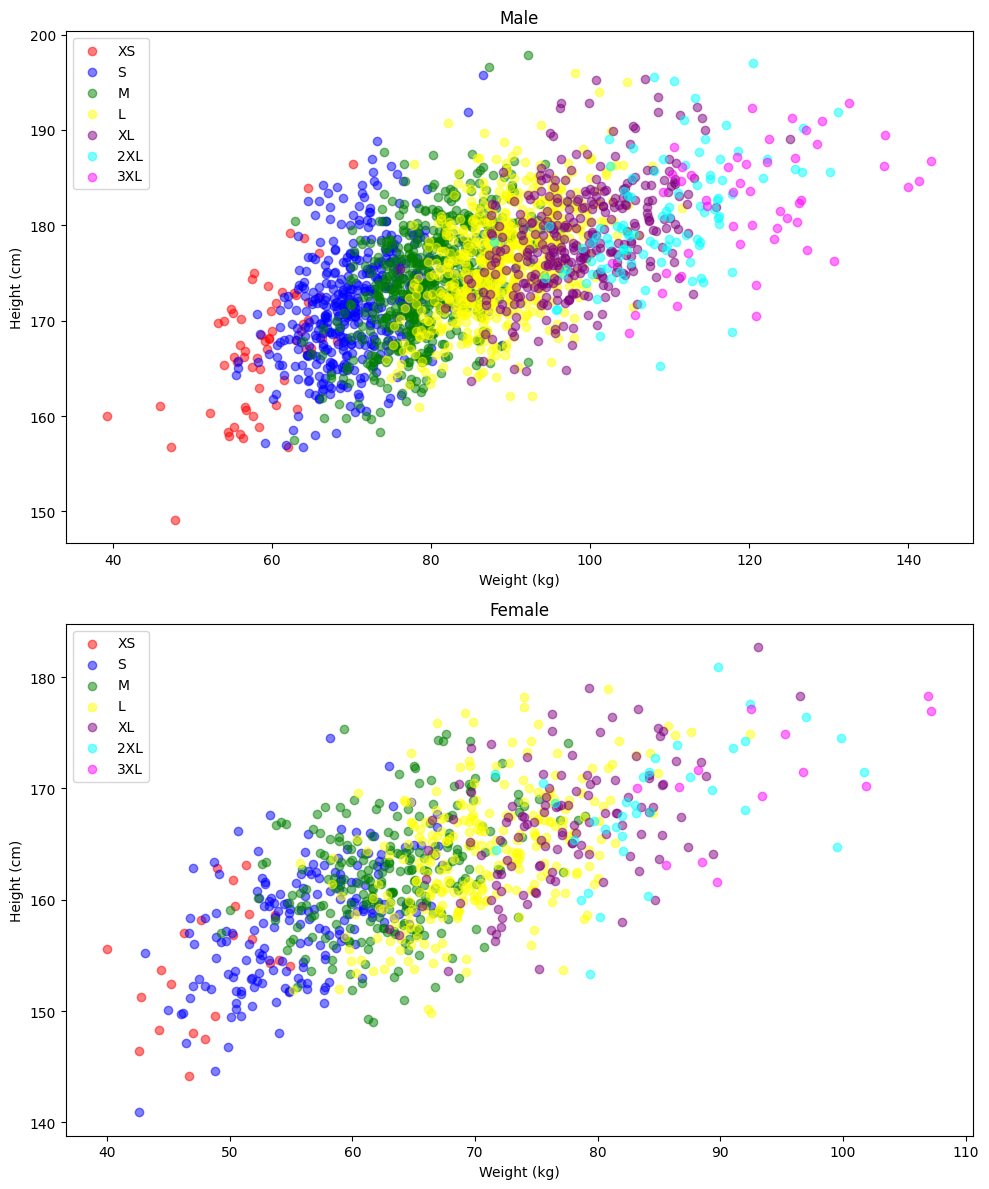

In [24]:
import matplotlib.pyplot as plt

# First let us define a dict to match a t-shirt size to a color
colors = {
    'XS': 'red',
    'S': 'blue',
    'M': 'green',
    'L': 'yellow',
    'XL': 'purple',
    '2XL': 'cyan',
    '3XL': 'magenta'
}

male_dataset = pd.read_csv('./data/male_sized.csv')
female_dataset = pd.read_csv('./data/female_sized.csv')
# For male_dataset
male_dataset.loc[:, 'stature'] = male_dataset['stature'] / 10
male_dataset.loc[:, 'weightkg'] = male_dataset['weightkg'] / 10

# For female_dataset
female_dataset.loc[:, 'stature'] = female_dataset['stature'] / 10
female_dataset.loc[:, 'weightkg'] = female_dataset['weightkg'] / 10

# Create plots for each gender
fig, axes = plt.subplots(nrows=2, figsize=(10, 12))

for ax, gender_data, gender in zip(axes, [male_dataset, female_dataset], ["Male", "Female"]):
    for size, color in colors.items():
        # Filter data by size
        size_data = gender_data[gender_data["t-shirt size"] == size]

        # Plot data
        ax.scatter(size_data["weightkg"], size_data["stature"], c=color, label=size, alpha=0.5)

    ax.set_title(gender)
    ax.set_xlabel("Weight (kg)")
    ax.set_ylabel("Height (cm)")
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

class KNNClassifier:
    def __init__(self, k=5):
        self.k = k
        self.X = None
        self.y = None
    
    def _calculate_distance(self, x1, x2):
        """
        Calculate the Eucaledian distance between two data points, x1 och x2
        """
        return ((x1 - x2)**2).sum() **0.5
    
    def _knn_predict(self, x):
        return sorted([
            (self._calculate_distance(x, measurment), self.y[i])
            for i, measurment in enumerate(self.X)
        ])[:self.k]


    def fit(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)

    def _predict(self, X):
        # X = [(178, 86), (164, 52)]
        predictions = []
        for x in X:
            neighbors = self._knn_predict(x) 
            prediction = self._predict(neighbors)
    